In [7]:
#|default_exp tmp

# Resnet18d up to 95.78%

## Init / Import

In [1]:
#| export
import pickle,gzip,math,os,time,shutil,torch,random
import fastcore.all as fc,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF,torch.nn.functional as F
from torchvision import transforms
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.augment import *
from miniai.challange.ct94ep5 import *
from miniai.utils import *
from miniai.accel import *
import timm
from miniai.challange.base import *

In [2]:
tds = setup_fasion_mnist()

Reseed: 1


  0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
# leaky=0.0, train_cb=MixedPrecision(), epochs=5, base_lr=2e-2, loss_func=F.cross_entropy, bs=256, sched_fn=lr_scheduler.OneCycleLR, opt_func=optim.AdamW,
# adding values to partial duplicates 
run = partial(run, tds=tds.cached)

In [4]:
upscale32 = Upscale(28, align=True, const=-0.800000011920929)
upscale = Upscale(28, align=True, const=-0.800000011920929)

In [5]:
run, model_base_resnet, timm_model, model9_ct

(functools.partial(<function run at 0x7f03f2d2e830>, tds={ train: (#60000), test: (#10000) }),
 <function miniai.challange.base.model_base_resnet()>,
 <function miniai.challange.base.timm_model(name, resize=Identity(), leaky=0.0, **kw)>,
 <function miniai.challange.base.model9_ct(**kw)>)

# lion, adamw, mixup
The relevant implementation of mixup is shown at the end of this notebook

In [10]:
# simplified Lion code from google's repo https://github.com/google/automl/blob/master/lion/lion_pytorch.py
from torch.optim.optimizer import Optimizer

class Lion(Optimizer):
    def __init__(self, params, lr=1e-4, betas=(0.9, 0.99), weight_decay=0.0):
        defaults = dict(lr=lr, betas=betas, weight_decay=weight_decay)
        super().__init__(params, defaults)
  
    @torch.no_grad()    
    def exp_avg(self, p): 
        exp_avg = self.state[p].get('exp_avg', None) 
        if exp_avg is None: exp_avg = torch.zeros_like(p)
        return exp_avg
    
    @torch.no_grad()
    def step(self):
        for group in self.param_groups:
            (beta1, beta2), lr = group['betas'], group['lr']
            for p in group['params']:
                if p.grad is None: continue
                exp_avg = self.exp_avg(p)
                
                plus_or_minus = torch.sign(exp_avg * beta1 + p.grad * (1 - beta1))
                p.add_(-lr, alpha=plus_or_minus) 
                exp_avg.mul_(beta2).add_(grad, alpha=1 - beta2) # inplace update

def lion(lr=2e-3,**kw): return dict(opt_func=Lion, base_lr=lr, **kw) 

In [7]:
#| export
import dadaptation
def dadapt_adam():return dict(opt_func=partial(dadaptation.DAdaptAdam, weight_decay=0.0), base_lr=1,)

In [8]:
#| export
def adamw(lr=1e-2, wd=0.01, **kw): return dict(opt_func=partial(optim.AdamW, weight_decay=wd), base_lr=1e-2, **kw)

In [9]:
#| export
from miniai.challange.base import MixUpFP16CB
def mixup(alpha=0.4,lbl_smooth=0.1, **kw): return dict(train_cb=MixUpFP16CB(alpha=alpha,use_prev=True, label_smoothing=lbl_smooth), **kw)

In [11]:
learn = run(timm_model('resnet18d', upscale32.bilinear(2), leaky=0.0,  drop_rate=0.4),
            lion(2e-3),
            train_cb=MixUpFP16CB(0.1, use_prev=True, label_smoothing=0.0),
            epochs=50, bs=2048, tta=True, fit=False)

Reseed: 1
Batch size 2048
Reseed: 1
{'accuracy': '0.100', 'loss': '2.381', 'epoch': 0, 'train': 'eval'}
Reseed: 1
{'accuracy': '0.100', 'loss': '2.381', 'epoch': 0, 'train': 'eval'}
TTA: 0.1


In [12]:
del learn.cbs[3]

In [13]:
learn.cbs+=[ProgressCB()]

Reseed: 1


accuracy,loss,epoch,train
0.320,1.973,0,train


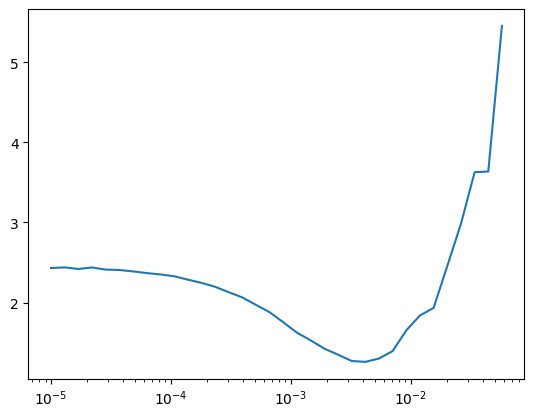

In [15]:
learn.lr_find()

In [14]:
#|export
def save_model(learn, name):
    from accelerate import Accelerator
    mdl_path = Path.home()/"models"/"fmnist"
    mdl_path.mkdir(parents=True,exist_ok=True)
    model=learn.cbs[-1].acc.unwrap_model(learn.model)
    state_dict = model.state_dict()
    learn.cbs[-1].acc.save(state_dict,  mdl_path/name)

# Experiements with resnet18d

## 5 epochs

Reseed: 1
Batch size 256
Reseed: 1


accuracy,loss,epoch,train
0.822,0.541,0,train
0.645,1.930,0,eval
0.904,0.262,1,train
0.903,0.282,1,eval
0.928,0.195,2,train
0.917,0.227,2,eval
0.949,0.139,3,train
0.936,0.184,3,eval
0.968,0.088,4,train
0.942,0.171,4,eval


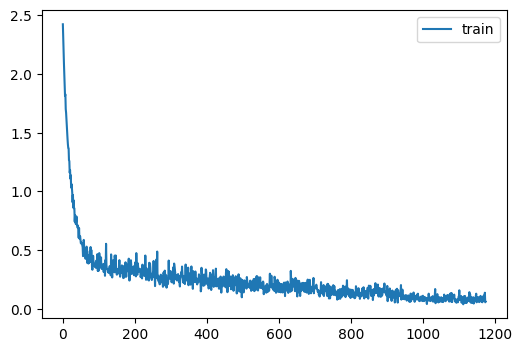

Fit 5 in: 35.41s, setup: 0.00s, 6.75 ± 0.25s per epoch, 0.03 ± 0.01s per batch


In [16]:
learn = run(timm_model('resnet18d', upscale32.bilinear(2), leaky=0.0,), 
    adamw(1e-2, wd=0.0, bs=256),
    epochs=5);

## 20 epochs

Reseed: 1
Batch size 512
Reseed: 1


accuracy,loss,epoch,train
0.682,0.954,0,train
0.808,0.537,0,eval
0.840,0.430,1,train
0.776,0.653,1,eval
0.867,0.362,2,train
0.847,0.467,2,eval
0.881,0.324,3,train
0.867,0.392,3,eval
0.890,0.299,4,train
0.867,0.377,4,eval


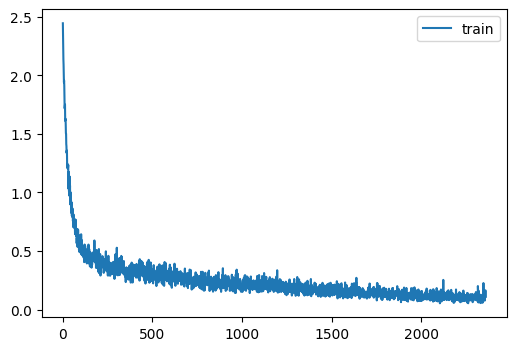

Fit 20 in: 114.48s, setup: 0.00s, 5.44 ± 0.03s per epoch, 0.04 ± 0.00s per batch
Reseed: 1
Reseed: 1
TTA: 0.95


In [23]:
learn = run(timm_model('resnet18d', upscale32.bilinear(2), leaky=0.0,  drop_rate=0.4),
            get_augcb(
                transforms.RandomCrop(28, padding=1, fill=-0.800000011920929),
                transforms.RandomHorizontalFlip(0.5),
                RandErase(pct=0.2)),
            adamw(1e-2,bs=512),
            epochs=20, tta=True)

## 50 epochs - 95.78% 

Reseed: 1
Batch size 512
Reseed: 1


accuracy,loss,epoch,train
0.329,2.058,0,train
0.617,1.335,0,eval
0.580,1.632,1,train
0.737,0.825,1,eval
0.709,1.383,2,train
0.821,0.541,2,eval
0.778,1.218,3,train
0.868,0.415,3,eval
0.807,1.139,4,train
0.891,0.359,4,eval


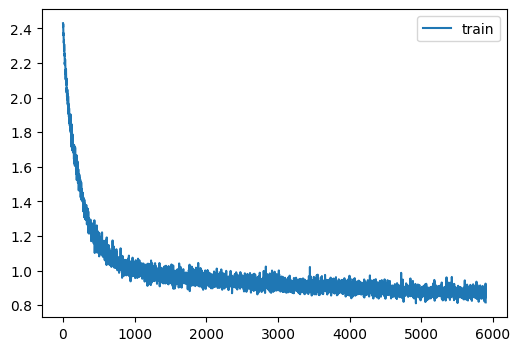

Fit 50 in: 288.39s, setup: 0.00s, 5.46 ± 0.04s per epoch, 0.04 ± 0.00s per batch
Reseed: 1
Reseed: 1
TTA: 0.9578


In [40]:
#95.78
learn = run(timm_model('resnet18d', upscale32.bilinear(2), leaky=0.0,  drop_rate=0.4),
            get_augcb(
                transforms.RandomCrop(28, padding=1, fill=-0.800000011920929),
                transforms.RandomHorizontalFlip(0.5),
                RandErase(pct=0.2)),
            lion(1e-3, bs=512),
            mixup(0.4, lbl_smooth=0.1),
            epochs=50, tta=True)

# Experiment with resnet50d 50 epochs- 95.82%

Reseed: 1
Batch size 256
Reseed: 1


accuracy,loss,epoch,train
0.519,1.678,0,train
0.824,0.534,0,eval
0.772,1.215,1,train
0.869,0.442,1,eval
0.797,1.151,2,train
0.874,0.414,2,eval
0.814,1.114,3,train
0.890,0.391,3,eval
0.818,1.098,4,train
0.890,0.408,4,eval


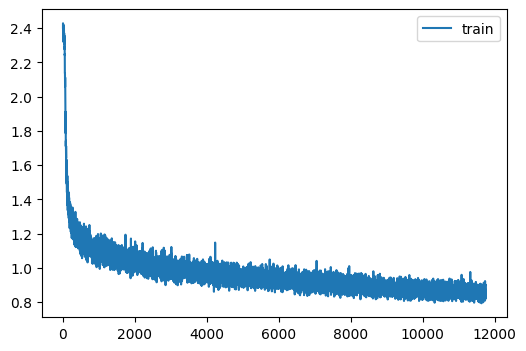

Fit 50 in: 1322.20s, setup: 0.00s, 25.69 ± 0.08s per epoch, 0.11 ± 0.00s per batch
Reseed: 1
Reseed: 1
TTA: 0.9582


In [97]:
learn = run(timm_model('resnet50d', upscale32.bilinear(2), leaky=0.0,  drop_rate=0.4),
            get_augcb(
                transforms.RandomCrop(28, padding=1, fill=-0.800000011920929),
                upscale32.bilinear(2),
                transforms.RandomHorizontalFlip(0.5),
                RandErase(pct=0.2)),
            train_cb=MixUpFP16CB(0.4, use_prev=True, label_smoothing=0.1),
            opt_func=partial(dadaptation.DAdaptAdam, weight_decay=0.0), base_lr=1,
            epochs=50, tta=True)

# Ablation of resnet18d
How use of mixup lion and adamw influence the result

## no mixup, lion(1e-3, bs=512)

Reseed: 1
Batch size 512
Reseed: 1


accuracy,loss,epoch,train
0.372,1.910,0,train
0.611,1.337,0,eval
0.645,1.166,1,train
0.739,0.799,1,eval
0.763,0.697,2,train
0.822,0.498,2,eval
0.846,0.421,3,train
0.867,0.405,3,eval
0.877,0.331,4,train
0.877,0.367,4,eval


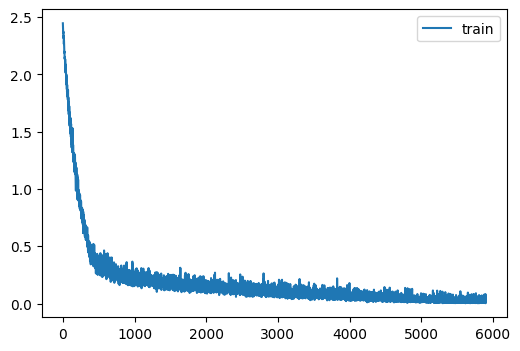

Fit 50 in: 279.25s, setup: 0.00s, 5.29 ± 0.02s per epoch, 0.04 ± 0.00s per batch
Reseed: 1
Reseed: 1
TTA: 0.9553


In [24]:
#95.53
learn = run(timm_model('resnet18d', upscale32.bilinear(2), leaky=0.0,  drop_rate=0.4),
            get_augcb(
                transforms.RandomCrop(28, padding=1, fill=-0.800000011920929),
                transforms.RandomHorizontalFlip(0.5),
                RandErase(pct=0.2)),
            lion(1e-3, bs=512),
            epochs=50, tta=True)

## no mixup, adamw(1e-2, bs=512) (instead of lion)

Reseed: 1
Batch size 512
Reseed: 1


accuracy,loss,epoch,train
0.676,0.982,0,train
0.810,0.528,0,eval
0.841,0.436,1,train
0.855,0.401,1,eval
0.871,0.352,2,train
0.862,0.407,2,eval
0.879,0.327,3,train
0.872,0.403,3,eval
0.886,0.307,4,train
0.876,0.381,4,eval


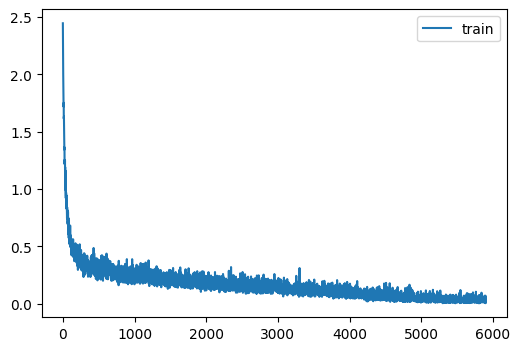

Fit 50 in: 287.40s, setup: 0.00s, 5.45 ± 0.03s per epoch, 0.04 ± 0.00s per batch
Reseed: 1
Reseed: 1
TTA: 0.9563


In [25]:
#95.63
learn = run(timm_model('resnet18d', upscale32.bilinear(2), leaky=0.0,  drop_rate=0.4),
            get_augcb(
                transforms.RandomCrop(28, padding=1, fill=-0.800000011920929),
                transforms.RandomHorizontalFlip(0.5),
                RandErase(pct=0.2)),
            adamw(1e-2, bs=512),
            epochs=50, tta=True)

## with mixup, adamw(1e-2, bs=512) (instead of lion)

Reseed: 1
Batch size 512
Reseed: 1


accuracy,loss,epoch,train
0.619,1.541,0,train
0.811,0.568,0,eval
0.774,1.222,1,train
0.840,0.467,1,eval
0.797,1.166,2,train
0.886,0.413,2,eval
0.814,1.117,3,train
0.874,0.448,3,eval
0.819,1.097,4,train
0.893,0.362,4,eval


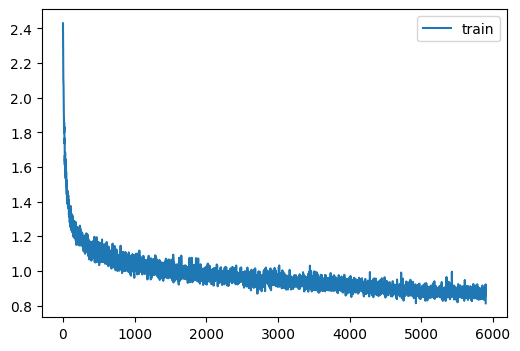

Fit 50 in: 297.22s, setup: 0.00s, 5.64 ± 0.05s per epoch, 0.04 ± 0.00s per batch
Reseed: 1
Reseed: 1
TTA: 0.9554


In [39]:
#95.54
learn = run(timm_model('resnet18d', upscale32.bilinear(2), leaky=0.0,  drop_rate=0.4),
            get_augcb(
                transforms.RandomCrop(28, padding=1, fill=-0.800000011920929),
                transforms.RandomHorizontalFlip(0.5),
                RandErase(pct=0.2)),
            adamw(1e-2, bs=512),
            mixup(0.4, lbl_smooth=0.1),
            epochs=50, tta=True)

# How was the Mixup Implemented

In [42]:
# this is just a combination of regular mixup with AccelerateCB to get fp16 speed of training
MixUpFP16CB??

Init signature:
MixUpFP16CB(
    alpha=0.4,
    use_prev=False,
    eta=0.1,
    per_batch=False,
    loss_func=<function mce_int at 0x7f03f2d2f370>,
    label_smoothing=0.0,
    **kw,
)
Docstring:      <no docstring>
Source:         class MixUpFP16CB(MixUpCB, AccelerateCB): pass
File:           ~/workspace/part2/course22p2/miniai/challange/base.py
Type:           type
Subclasses:     

In [47]:
from miniai.mixup import MixUpCB, mixup_data_int, mce_int
# data mixing function
mixup_data_int??

Signature:
mixup_data_int(
    b2,
    b1=None,
    sampler=<bound method Distribution.sample of Beta()>,
    classes=10,
    permute_1=True,
)
Source:   
def mixup_data_int(b2, b1=None, sampler=torch.distributions.Beta(tensor(0.5), tensor(0.5)).sample, classes=10, permute_1=True):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    r = SimpleNamespace()    
    if b1 is None: b1=b2 # first batch uses it self
    x1,y1 = b1
    x2,y2 = b2
    
    if x1.shape[0] != x2.shape[0]: x1,y1=x2,y2 # last batch uses it self

    batch_size = x2.shape[0]
    r.lam = sampler([batch_size]).to(x2.device)
    
    # permute prev batch
    if permute_1:
        r.index = torch.randperm(batch_size).to(x2.device)
        x1,y1 = x1[r.index], y1[r.index]
    # x2 + lam*(x1-x2)
    r.mixed_x = torch.lerp(x2, x1, r.lam.reshape(-1,*[1]*(len(x2.shape)-1)))
    r.y1 = y1
    r.y2 = y2
    r.y = torch.cat([y2[:,None],y1[:,None]],dim=1)
    r.top1y=torch.gather(r.y, 1, (r.lam.expand(r.y1.shape) > 

In [49]:
# loss function for mixup
mce_int?? 

Signature: mce_int(preds, r, reduction=True, eta=None, **kw)
Docstring: <no docstring>
Source:   
def mce_int(preds, r, reduction=True, eta=None, **kw):
    ce = torch.lerp(F.cross_entropy(preds, r.y2, reduction='none', **kw), 
                    F.cross_entropy(preds, r.y1, reduction='none', **kw), r.lam)
    return ce.mean(-1) if reduction else ce
File:      ~/workspace/part2/course22p2/miniai/mixup.py
Type:      function

In [51]:
# An a callback to stick the above functions in to the training
MixUpCB??

Init signature:
MixUpCB(
    alpha=0.4,
    use_prev=False,
    eta=0.1,
    per_batch=False,
    loss_func=<function mce_int at 0x7f03f2d2f370>,
    label_smoothing=0.0,
    **kw,
)
Docstring:      <no docstring>
Source:        
class MixUpCB(TrainCB):
    def __init__(self,alpha=0.4, use_prev=False, eta=0.1, per_batch=False, loss_func=mce_int, label_smoothing=0.0, **kw): 
        super().__init__(**kw)
        self.alpha = alpha or 0.0
        self.dist = torch.distributions.Beta(self.alpha, self.alpha)
        self.prev = None
        self.use_prev = use_prev
        self.eta = eta 
        self.per_batch = per_batch
        self.loss_func = loss_func
        self.label_smoothing = label_smoothing
    def before_epoch(self, learn):
        self.prev = None
            
    def sample(self, shape): 
        if self.per_batch: return self.dist.sample([1])
        return self.dist.sample(shape)
    
    def before_batch(self, learn):
        if learn.training and self.alpha: 
         